In [1]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline

import xgboost as xgb

import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/booksdata/scaled_test.csv
/kaggle/input/booksdata/final.csv
/kaggle/input/booksdata/scaled_train.csv
/kaggle/input/booksdata/train_data.csv
/kaggle/input/booksdata/test_data.csv


In [2]:
#Change display to see more rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load the Datasets

In [3]:
#Load dataset
dataset = pd.read_csv('/kaggle/input/booksdata/final.csv', index_col=0)
dataset

,edition,pages,rating,rating_count,review_count,missing_ed,missing_desc,length,quality,Fiction,Fantasy,Romance,Young Adult,Nonfiction,Historical,Historical Fiction,Contemporary,Classics,Mystery,Cultural,Paranormal,Science Fiction,Childrens,Literature,Other,fauthor_rating,fauthor_nbooks,authors_rating,authors_nbooks,nauthors,a1plus,a3plus,a5plus,a10plus,fmt_Audio,fmt_Digital,fmt_Hardcover,fmt_Missing,fmt_Other,fmt_Paperback
0,0,870.0,4.48,2041594,33264,0.0,1.0,3.0,1.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.244412,34,4.388873,20.000000,2,1,0,0,0,0,0,0,0,0,1
1,0,193.0,4.21,1155911,23919,1.0,1.0,1.0,1.0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,4.156957,23,4.156957,23.000000,1,0,0,0,0,0,0,0,0,0,1
2,0,64.0,4.37,789681,15694,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,4.241818,11,4.241818,11.000000,1,0,0,0,0,0,0,1,0,0,0
3,0,481.0,3.81,1668594,43699,1.0,1.0,3.0,1.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.818571,14,3.818571,14.000000,1,0,0,0,0,0,0,0,0,0,1
4,0,239.0,4.07,411153,9166,1.0,1.0,2.0,1.0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4.085000,18,4.077143,9.666667,3,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38411,0,106.0,3.92,387,39,1.0,1.0,1.0,0.0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,3.920000,1,3.920000,1.000000,2,1,0,0,0,0,0,0,0,0,1
38412,0,336.0,3.60,3529,531,1.0,1.0,2.0,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,3.600000,1,3.600000,1.000000,1,0,0,0,0,0,0,0,0,0,1
38413,1,368.0,3.67,5827,816,0.0,1.0,2.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,3.767500,4,3.767500,4.000000,1,0,0,0,0,0,0,1,0,0,0
38414,0,399.0,3.51,3717,661,1.0,1.0,2.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3.510000,1,3.510000,1.000000,1,0,0,0,0,0,0,1,0,0,0


In [4]:
#define independent variables and dependent variable (quality)
X = dataset.drop(columns=['quality'])
y = dataset[['quality']]

#Create test and train test while shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Save unscaled train and test data
X_train.join(y_train).to_csv('/kaggle/working/train_data.csv')
X_test.join(y_test).to_csv('/kaggle/working/test_data.csv')

In [5]:
#Create standardscaler
scaler = MinMaxScaler()

#Fit abd transform scaler on training data
training = scaler.fit_transform(X_train)

#Transform test data based on fitted scaler
testing = scaler.transform(X_test)

In [6]:
#Save scaled training and test data along with the depedent variables
pd.DataFrame(training, columns=X_train.columns, index=X_train.index).join(y_train).to_csv('/kaggle/working/scaled_train.csv')
pd.DataFrame(testing, columns=X_test.columns, index=X_test.index).join(y_test).to_csv('/kaggle/working/scaled_test.csv')

## Train and Test Sets

In [7]:
#Load relevant datasets
train = pd.read_csv('/kaggle/input/booksdata/scaled_train.csv', index_col=0).reset_index(drop=True)
test = pd.read_csv('/kaggle/input/booksdata/scaled_test.csv', index_col=0).reset_index(drop=True)

In [8]:
#Split the scaled dataset into independent and dependent variables
X_train = train.drop(columns=['quality'])
X_test = test.drop(columns=['quality'])
y_train = train['quality']
y_test = test['quality']

X_train.shape, y_train.shape

((26891, 39), (26891,))

## Evaluations
Helper functions to evaluate the model.

In [9]:
def plot_roc(fpr1, tpr1, fpr0, tpr0):
    """Plot the ROC curve."""
    
    plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve for 1')
    plt.plot(fpr0, tpr0, color='navy', lw=2, label='ROC curve for 0')
    plt.plot([0,1], [0,1], lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.legend()
    plt.show()

In [10]:
def evaluate(model, X_train, X_test, y_train, y_test):
    """Obtain the metrics for evaluation of the model."""
    
    #Print model name
    print(model)
    
    #Fit and predict the model
    fit_start = time.time()
    model.fit(X_train, y_train)
    fit_end = time.time()
    
    train_pred = model.predict(X_train)
    
    pred_start = time.time()
    y_pred = model.predict(X_test)
    pred_end = time.time()
    
    #Print execution time
    print('Model Fit Time: ', fit_end - fit_start, 's')
    print('Model Prediction Time: ', pred_end - pred_start, 's\n')
    
    #Print reports
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    #Get probability estimates for roc curve
    probs = model.predict_proba(X_test)
    y_score1 = probs[:,1]
    y_score0 = probs[:,0]
    
    #Calculate ROC metrics
    fpr1, tpr1, thresholds1 = roc_curve(y_test, y_score1)
    fpr0, tpr0, thresholds0 = roc_curve(y_test, y_score0)
    
    #Print AUC
    print("AUC for classifying as good (1): {}\nAUC for classifying as bad (0): {}.".format(
        auc(fpr1, tpr1), auc(fpr0, tpr0)))
    
    plot_roc(fpr1, tpr1, fpr0, tpr0)

## Modeling
### Baseline

In [11]:
#Create dummy model with uniform strategy
dummy = DummyClassifier(strategy='uniform', random_state=42)

#Fit and predict model on scaled data
dummy.fit(X_train, y_train)
dummy.predict(X_test)

#Obtain dummy score
dummy.score(X_test, y_test)

0.5048156182212581

DummyClassifier(random_state=42, strategy='uniform')
Model Fit Time:  0.0013422966003417969 s
Model Prediction Time:  0.0004715919494628906 s

              precision    recall  f1-score   support

         0.0       0.51      0.51      0.51      5766
         1.0       0.50      0.50      0.50      5759

    accuracy                           0.50     11525
   macro avg       0.50      0.50      0.50     11525
weighted avg       0.50      0.50      0.50     11525

[[2914 2852]
 [2855 2904]]
AUC for classifying as good (1): 0.5
AUC for classifying as bad (0): 0.5.


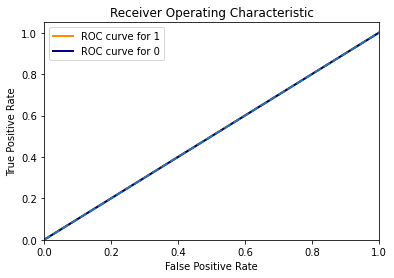

In [12]:
evaluate(dummy, X_train, X_test, y_train, y_test)

### XGBoost

In [13]:
#Create xgboost model
xgb_cl = xgb.XGBClassifier(objective="binary:logistic", verbosity=0)

#fit 
xgb_cl.fit(X_train, y_train)

#predict
preds = xgb_cl.predict(X_test)

#score
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[3820 1946]
 [2202 3557]]
              precision    recall  f1-score   support

         0.0       0.63      0.66      0.65      5766
         1.0       0.65      0.62      0.63      5759

    accuracy                           0.64     11525
   macro avg       0.64      0.64      0.64     11525
weighted avg       0.64      0.64      0.64     11525



Fine tune hyperparameters:

In [14]:
#Create xgboost model
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', verbosity=0)

#Create model parameters to iterate over
params = {'learning_rate': [0.01,0.05,0.1,0.2],
          'gamma': [0,0.25,0.5,1],
          'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 2],
          'reg_lambda': [0, 1e-5, 1e-2, 0.1, 1, 2],
          'max_depth': [3,5,10,15]
         }

#Create randomized search cv pipeline
xgb_cv = RandomizedSearchCV(xgb_clf, param_distributions=params, cv=5, scoring='roc_auc', verbose=10)

#Fit model on training set
xgb_cv.fit(X_train, y_train)

#Print the best parameters and score
print(xgb_cv.best_params_, xgb_cv.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] reg_lambda=1, reg_alpha=0.1, max_depth=15, learning_rate=0.2, gamma=0.25 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg_lambda=1, reg_alpha=0.1, max_depth=15, learning_rate=0.2, gamma=0.25, score=0.697, total=  11.2s
[CV] reg_lambda=1, reg_alpha=0.1, max_depth=15, learning_rate=0.2, gamma=0.25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV]  reg_lambda=1, reg_alpha=0.1, max_depth=15, learning_rate=0.2, gamma=0.25, score=0.666, total=  10.7s
[CV] reg_lambda=1, reg_alpha=0.1, max_depth=15, learning_rate=0.2, gamma=0.25 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s


[CV]  reg_lambda=1, reg_alpha=0.1, max_depth=15, learning_rate=0.2, gamma=0.25, score=0.669, total=  11.1s
[CV] reg_lambda=1, reg_alpha=0.1, max_depth=15, learning_rate=0.2, gamma=0.25 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.1s remaining:    0.0s


[CV]  reg_lambda=1, reg_alpha=0.1, max_depth=15, learning_rate=0.2, gamma=0.25, score=0.683, total=  10.7s
[CV] reg_lambda=1, reg_alpha=0.1, max_depth=15, learning_rate=0.2, gamma=0.25 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.8s remaining:    0.0s


[CV]  reg_lambda=1, reg_alpha=0.1, max_depth=15, learning_rate=0.2, gamma=0.25, score=0.687, total=  10.7s
[CV] reg_lambda=0.1, reg_alpha=0, max_depth=3, learning_rate=0.1, gamma=0.5 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.5s remaining:    0.0s


[CV]  reg_lambda=0.1, reg_alpha=0, max_depth=3, learning_rate=0.1, gamma=0.5, score=0.711, total=   1.8s
[CV] reg_lambda=0.1, reg_alpha=0, max_depth=3, learning_rate=0.1, gamma=0.5 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   56.3s remaining:    0.0s


[CV]  reg_lambda=0.1, reg_alpha=0, max_depth=3, learning_rate=0.1, gamma=0.5, score=0.681, total=   2.3s
[CV] reg_lambda=0.1, reg_alpha=0, max_depth=3, learning_rate=0.1, gamma=0.5 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   58.6s remaining:    0.0s


[CV]  reg_lambda=0.1, reg_alpha=0, max_depth=3, learning_rate=0.1, gamma=0.5, score=0.684, total=   1.8s
[CV] reg_lambda=0.1, reg_alpha=0, max_depth=3, learning_rate=0.1, gamma=0.5 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[CV]  reg_lambda=0.1, reg_alpha=0, max_depth=3, learning_rate=0.1, gamma=0.5, score=0.696, total=   1.8s
[CV] reg_lambda=0.1, reg_alpha=0, max_depth=3, learning_rate=0.1, gamma=0.5 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min remaining:    0.0s


[CV]  reg_lambda=0.1, reg_alpha=0, max_depth=3, learning_rate=0.1, gamma=0.5, score=0.698, total=   1.9s
[CV] reg_lambda=1, reg_alpha=0, max_depth=5, learning_rate=0.05, gamma=0.25 
[CV]  reg_lambda=1, reg_alpha=0, max_depth=5, learning_rate=0.05, gamma=0.25, score=0.715, total=   4.0s
[CV] reg_lambda=1, reg_alpha=0, max_depth=5, learning_rate=0.05, gamma=0.25 
[CV]  reg_lambda=1, reg_alpha=0, max_depth=5, learning_rate=0.05, gamma=0.25, score=0.686, total=   3.4s
[CV] reg_lambda=1, reg_alpha=0, max_depth=5, learning_rate=0.05, gamma=0.25 
[CV]  reg_lambda=1, reg_alpha=0, max_depth=5, learning_rate=0.05, gamma=0.25, score=0.686, total=   3.2s
[CV] reg_lambda=1, reg_alpha=0, max_depth=5, learning_rate=0.05, gamma=0.25 
[CV]  reg_lambda=1, reg_alpha=0, max_depth=5, learning_rate=0.05, gamma=0.25, score=0.701, total=   3.1s
[CV] reg_lambda=1, reg_alpha=0, max_depth=5, learning_rate=0.05, gamma=0.25 
[CV]  reg_lambda=1, reg_alpha=0, max_depth=5, learning_rate=0.05, gamma=0.25, score=0.704,

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.3min finished


{'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.25} 0.6984765013128754


In [15]:
#best xgboost model
xgb_best = xgb.XGBClassifier(objective='binary:logistic', verbosity=0, reg_lambda=1, reg_alpha=2, max_depth=5, learning_rate=0.1, gamma=0)

#Fit and predict model on training set
xgb_best.fit(X_train, y_train)
preds_best = xgb_best.predict(X_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=2, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
Model Fit Time:  4.147428035736084 s
Model Prediction Time:  0.024336814880371094 s

              precision    recall  f1-score   support

         0.0       0.64      0.68      0.66      5766
         1.0       0.66      0.61      0.63      5759

    accuracy                           0.65     11525
   macro avg       0.65      0.65      0.65     11525
weighted avg    

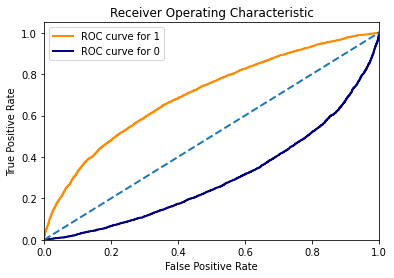

In [16]:
evaluate(xgb_best, X_train, X_test, y_train, y_test)

### Test XGBoost model based on scoring on logged verbosity

In [17]:
#test xgboost model
xgb_test = xgb.XGBClassifier(objective='binary:logistic', verbosity=0, reg_lambda=2, reg_alpha=1, max_depth=10, learning_rate=0.1, gamma=0.25)

#Fit and predict model on training set
xgb_test.fit(X_train, y_train)
preds_test = xgb_test.predict(X_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.25, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1, reg_lambda=2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
Model Fit Time:  8.669475793838501 s
Model Prediction Time:  0.04972958564758301 s

              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65      5766
         1.0       0.65      0.61      0.63      5759

    accuracy                           0.64     11525
   macro avg       0.64      0.64      0.64     11525
weighted avg 

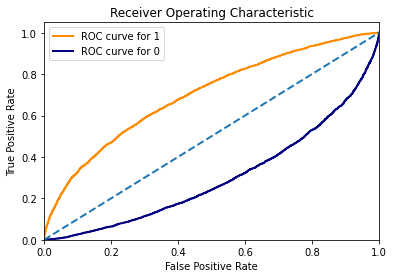

In [18]:
evaluate(xgb_test, X_train, X_test, y_train, y_test)

In [19]:
# #Create xgboost model
# xgb_clf = xgb.XGBClassifier(objective='binary:logistic', verbosity=0)

# #Create model parameters to iterate over
# params = {'learning_rate': [0.01,0.05,0.1,0.2],
#           'gamma': [0,0.25,0.5,1],
#           'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 2],
#           'reg_lambda': [0, 1e-5, 1e-2, 0.1, 1, 2],
#           'max_depth': [3,5,10,15]
#          }

# #Create randomized search cv pipeline
# xgb_cv = GridSearchCV(xgb_clf, param_grid=params, cv=5, scoring='roc_auc', verbose=10)

# #Fit model on training set
# xgb_cv.fit(X_train, y_train)

# #Print the best parameters and score
# print(xgb_cv.best_params_, xgb_cv.best_score_)